In [2]:
# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import locale
import pyansys
import ipywidgets as widgets
from ipywidgets import interactive, interact_manual, interact
from subprocess import call
import pyvista as pv
import itkwidgets

# Local imports
from femodel import Threepartmodel
from util_mapdl import Material


locale.setlocale(locale.LC_ALL, 'de_DE')
plt.rcParams['axes.formatter.use_locale'] = True

#### Abhängigkeit des Konvergenzverhaltens von PSO-Parametern:

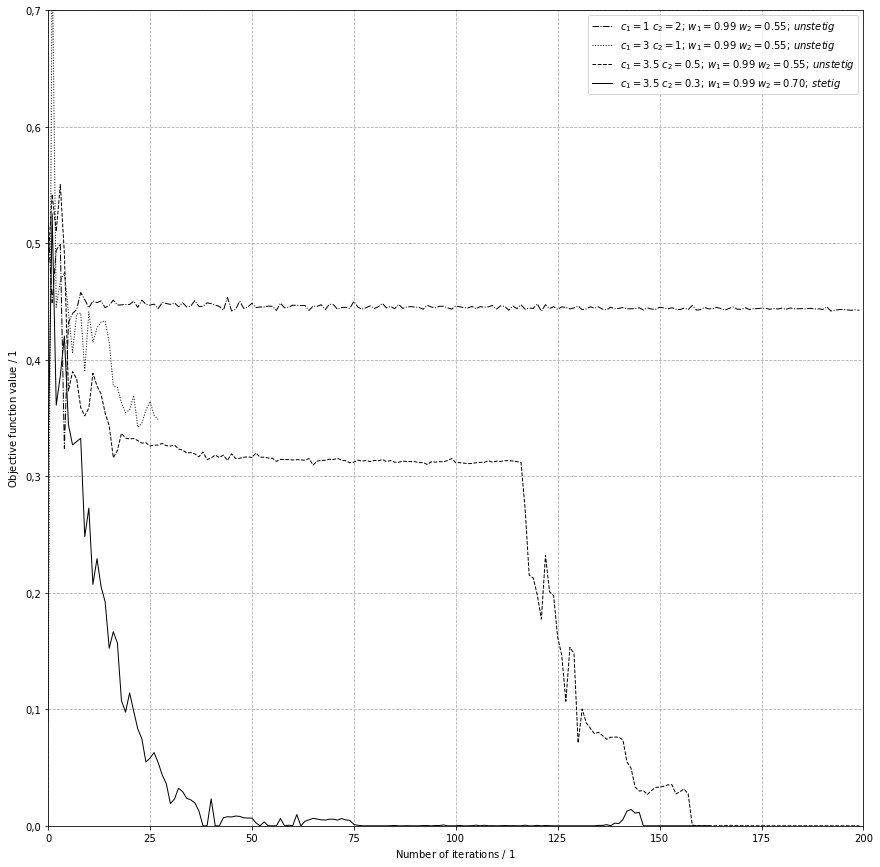

In [3]:
solution_2010 = pd.read_csv('./auswertung/solution_20-10_99-50_nx.csv')
solution_3010 = pd.read_csv('./auswertung/solution_30-10_99-55_nx.csv')
solution_3505 = pd.read_csv('./auswertung/solution_35-05_99-55_nx.csv')
solution_3503 = pd.read_csv('./auswertung/solution_35-03_99-70_catia_2.csv')

fig, ax = plt.subplots(figsize=(15, 15))

data =[[solution_2010, 'dashdot', 'black', '$c_{1}=1\,\,c_{2}=2;\,w_{1}=0.99\,\,w_{2}=0.55;\,unstetig$'],
       [solution_3010, 'dotted', 'black', '$c_{1}=3\,\,c_{2}=1;\,w_{1}=0.99\,\,w_{2}=0.55;\,unstetig$'],
       [solution_3505, 'dashed', 'black', '$c_{1}=3.5\,\,c_{2}=0.5;\,w_{1}=0.99\,\,w_{2}=0.55;\,unstetig$'],
       [solution_3503, 'solid', 'black', '$c_{1}=3.5\,\,c_{2}=0.3;\,w_{1}=0.99\,\,w_{2}=0.70;\,stetig$'],]

for dataset in data:
    dataset[0].plot(ax=ax,
                    y='F',
                    linestyle=dataset[1],
                    color=dataset[2],
                    linewidth=1,
                    label=dataset[3],
                    # marker='x',
                    )
    
ax.set_xlabel('Number of iterations / $1$')
ax.set_ylabel('Objective function value / $1$')
ax.set_xlim(0,200)
ax.set_ylim(0,0.7)
ax.set_box_aspect(1)
ax.grid(True, which='major',linestyle='dashed')
ax.legend()

In [5]:
solution_3503 = pd.read_csv('./auswertung/solution_rho.csv')

#### Auswertung der gefundenen Optima:

In [6]:
# %% Run ANSYS and instantiate FE-Model

print('Run ANSYS and instantiate FE-Model')

ansys_path = '/home/y0065120/Dokumente/Leichtwerk/Projects/ansys-0/'
jobname ='job-0'

mapdl = pyansys.launch_mapdl(run_location=ansys_path,
                             nproc=2,
                             override=True,
                             loglevel='error',
                             additional_switches='-smp -d X11C',
                             jobname=jobname,
                             allow_ignore=True,
                             mode='console')

n_sec = 20

femodel = Threepartmodel(mapdl,
                         mesh_density_factor=1,
                         propeller = [],
                         n_sec=n_sec)

femodel.materials = {'flaxpreg': Material(mapdl, 'FLAXPREG-T-UD', 1),
                     'balsa': Material(mapdl, 'balsaholz', 2)}

femodel.element_data = pd.read_csv('./mf3218/element_data.csv', index_col=(0))

Run ANSYS and instantiate FE-Model


In [13]:
@interact(number=widgets.IntSlider(min=0, max=len(solution_3503['F'])-1, value=len(solution_3503['F'])-1, description='Iteration Number'))
def get_iteration_dataset(number):
    global_vars = list(solution_3503.iloc[number, [82, 83]])
    rho = list(solution_3503.iloc[number, [i*2 + 84 for i in range(14)]])
    div = list(solution_3503.iloc[number, [i*2 + 85 for i in range(14)]])
        
    items = {}
    items['phi0'] =widgets.FloatSlider(value=global_vars[0],min=0.,max=180., description='phi0')
    items['phi1'] =widgets.FloatSlider(value=global_vars[1],min=0.,max=180., description='phi1')

    for i in range(14):
        items['rho' + str(i)] = widgets.FloatSlider(value=rho[i],min=0.,max=1.,step=0.01, description='rho' + str(i))
        items['div' + str(i)] = widgets.FloatSlider(value=div[i],min=0.,max=1.,step=0.01, description='div' + str(i))
    
    @interact_manual(gui=widgets.Checkbox(value=False, description='Open APDL Gui', disabled=False),**items)
    def solve_femodel(gui,**kwargs):
            global_vars = []
            global_vars.append(kwargs['phi0'])
            global_vars.append(kwargs['phi1'])
            
            args = []
            for i in range(14):
                args.append((kwargs['rho' + str(i)], kwargs['div' + str(i)]))
            for i in range(6):
                args.append((0, 0.5))
    
            femodel.clear()
            femodel.cdread()
            femodel.change_design_variables(global_vars, *args)
            femodel.__solve__()
    
            mass , i_f, i_m = femodel.post_processing()
        
            if gui:
                call('cp mf3218/plasma.cmap /tmp/ansys_tmp/', shell=True)
                mapdl.open_gui()
            
            fig3, ax3 = plt.subplots(figsize=(25.5, 12))
            
            plt.subplot(2,1,1)
            
            plt.plot(i_f, marker='x', label='i_f')
            plt.plot(i_m, marker='x', label='i_m')
            plt.xlim(0,19)
            plt.xticks(np.linspace(0,19,20))
            plt.ylim(0,1.2)
            plt.grid(True, which='major', linestyle='--')
            plt.xlabel('Section Number')
            plt.ylabel('Versagensindex nach Puck / $1$')
            plt.legend()
            
            plt.subplot(2,1,2)
            
            plt.plot([kwargs['rho' + str(i)] for i in range(14)], label='rho', marker='x')
            plt.plot([kwargs['div' + str(i)] for i in range(14)], label='div', marker='x')
            plt.xlim(0,19)
            plt.xticks(np.linspace(0,19,20))
            plt.ylim(0,1)
            plt.grid(True, which='major', linestyle='--')
            plt.ylabel('Wert der Designvariablen')
            plt.xlabel('Section Number')
            plt.legend()
            
            print('Masse: ' + str(np.round(mass*1e6,2)) + 'g')
            tikzplotlib.save("designvars.tex")


interactive(children=(IntSlider(value=199, description='Iteration Number', max=199), Output()), _dom_classes=(…

In [14]:
@interact_manual(switch=widgets.Checkbox(value=True, description='True = Fib', disabled=False),
                 layer=widgets.IntSlider(min=1, max=5, value=1, description='Layer:'))
def plot_puck(layer, switch):
    mapdl.post1()
    mapdl.layer(layer)
    
    if switch:
        mapdl.etable('fib','fail','pfib')
    else:
        mapdl.etable('fib','fail','pmat')

    with open('pretab.txt', 'w') as f:
        f.write(mapdl.pretab('fib'))

    etable = []
    with open('pretab.txt', 'r') as f:
        for line_number, line in enumerate(f):
            split_line = line.split()
            try:
                etable.append([int(split_line[0]), float(split_line[1])])
            except:
                pass
    etable=np.array(etable)          

    etb_scalar = []
    for elem in mapdl.result.grid['ansys_elem_num']:
        etb_scalar.append(etable[elem-1,1])
    etb_scalar = np.array(etb_scalar)

    #plotter = pv.Plotter(notebook=True)
    #plotter = pv.Plotter()
    plotter = pv.PlotterITK()
    plotter.add_mesh(mapdl.result.grid,
                     scalars=etb_scalar, #etable[:,1],
                     #cmap='plasma',
                     #clim=[0,1],
                     )
    #plotter.show_axes()
    #plotter.set_background(color='w')
    #plotter.add_scalar_bar(position_x=0.2)
    cpos = plotter.show(cpos=[0, 0, 1],
                        cmap='coolwarm'
                       # use_ipyvtk=True,
                       ) 

interactive(children=(IntSlider(value=1, description='Layer:', max=5, min=1), Checkbox(value=True, description…

In [6]:
@interact_manual(column='Pressure by Lift')
def plot_column(column):

    etable=np.array(femodel.element_data[column])          

    etb_scalar = []
    for elem in mapdl.result.grid['ansys_elem_num']:
        etb_scalar.append(etable[elem-1])
    etb_scalar = np.array(etb_scalar)

    #plotter = pv.Plotter(notebook=True)
    #plotter = pv.Plotter()
    plotter = pv.PlotterITK()
    plotter.add_mesh(mapdl.result.grid,
                     scalars=etb_scalar, #etable[:,1],
                     #cmap='plasma',
                     #clim=[0,1],
                     )
    #plotter.show_axes()
    #plotter.set_background(color='w')
    #plotter.add_scalar_bar(position_x=0.2)
    cpos = plotter.show(cpos=[0, 0, 1],
                        cmap='coolwarm'
                       # use_ipyvtk=True,
                       ) 

interactive(children=(Text(value='Pressure by Lift', description='column'), Button(description='Run Interact',…

In [7]:
grid = mapdl.result.grid
points = list(np.array(grid.points))

listpoints = []
for x in points:
    listpoints.append(list(x))
    
listpoints = sorted(listpoints,key=lambda l:l[1])
listpoints = np.array(listpoints)
listpoints[:,1] = np.round(listpoints[:,1],0)


In [8]:
listpoints

array([[-6.39999871e+00,  5.00000000e+01, -3.80015414e-07],
       [-5.64578795e+00,  5.00000000e+01, -4.53247598e-07],
       [-4.89157718e+00,  5.00000000e+01, -5.26479779e-07],
       ...,
       [ 2.55500896e+01,  4.12000000e+02, -1.12433351e+00],
       [ 2.61615010e+01,  4.12000000e+02, -1.31813334e+00],
       [ 2.67690983e+01,  4.12000000e+02, -1.52354616e+00]])

In [9]:
grid = mapdl.result.grid
points = list(np.array(grid.points))

df = pd.DataFrame(points, columns=['x', 'y', 'z'])
df['y'] = df['y'].round(0)
df=df.sort_values(by=['y', 'x'])

In [10]:
pointsarray = np.array(df)
flag = 0
with open('surface.txt', 'w') as f:
    for idline, line in enumerate(pointsarray):
        if line[1] != flag:
            flag = line[1]
            f.write('\n')
        
        f.write('(%s, %s, %s)\n' % (line[1], line[0], line[2]))

In [11]:
mapdl.nsle('s','corner')

df = pd.DataFrame(mapdl.mesh.nodes, columns=['x', 'y', 'z'])
df['y'] = df['y'].round(0)
df=df.sort_values(by=['y', 'x'])

pointsarray = np.array(df)
flag = 0
with open('surface.txt', 'w') as f:
    for idline, line in enumerate(pointsarray):
        if line[1] != flag:
            flag = line[1]
            f.write('\n')
        
        f.write('(%s, %s, %s)\n' % (line[1], line[0], line[2]))

AssertionError: Number of manager items must equal union of block items
# manager items: 3, # tot_items: 0

In [ ]:
df